<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/inception%2Bsvmpca91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
# Define the path to your image directories for healthy and ill samples
normal_path = "/content/drive/MyDrive/newdata/normal"
ill_path = "/content/drive/MyDrive/newdata/ill"

# Create lists to store image data and labels
dataset_images = []
dataset_labels = []

# Reading images from the normal directory
for files in os.listdir(normal_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(normal_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(0)  # Label for healthy images

# Reading images from the ill directory
for files in os.listdir(ill_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(ill_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(1)  # Label for ill images

# Convert the lists to NumPy arrays
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)

# Normalize pixel values to the range [0, 1]
dataset_images = dataset_images / 255.0

seed = 42  # You can use any integer value as the seed
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_images, dataset_labels, test_size=0.1, random_state=seed)


# Calculate the total number of images
total_images = len(dataset_images)
print("Total number of images:", total_images)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_images, dataset_labels, test_size=0.1, random_state=seed)

# Calculate the number of images in the training set
num_train_images = len(X_train)
print("Number of images in the training set:", num_train_images)

# Calculate the number of images in the testing set
num_test_images = len(X_test)
print("Number of images in the testing set:", num_test_images)



Total number of images: 178
Number of images in the training set: 160
Number of images in the testing set: 18


In [5]:
# Create an InceptionV3 model for feature extraction
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the InceptionV3-based model on the training dataset
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the InceptionV3-based model for both training and testing datasets
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Apply Principal Component Analysis (PCA) to reduce dimensionality
n_components = min(X_train_features.shape[0], X_train_features.shape[1])  # Set it to the minimum
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Define a range of hyperparameters to search over for SVM
param_grid = {
    'C': [1, 10, 50, 70, 100],  # Values of regularization parameter C
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Different kernel types to try
    'class_weight': [None, 'balanced']
}

# Create the SVM classifier
svm_classifier = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data with PCA features
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/10
5/5 [==============================] - 61s 11s/step - loss: 0.7149 - accuracy: 0.5437 - val_loss: 0.6878 - val_accuracy: 0.5556
Epoch 2/10
5/5 [==============================] - 30s 6s/step - loss: 0.6099 - accuracy: 0.6625 - val_loss: 0.6033 - val_accuracy: 0.7222
Epoch 3/10
5/5 [==============================] - 29s 6s/step - loss: 0.5465 - accuracy: 0.7625 - val_loss: 0.6045 - val_accuracy: 0.6667
Epoch 4/10
5/5 [==============================] - 30s 6s/step - loss: 0.5019 - accuracy: 0.7750 - val_loss: 0.5775 - val_accuracy: 0.7778
Epoch 5/10
5/5 [==============================] - 31s 6s/step - loss: 0.4653 - accuracy: 0.8062 - val_loss: 0.5507 - val_accuracy: 0.8333
Epoch 6/10
5/5 [==============================] - 29s 6s/step - loss: 0.4341 - accuracy: 0.8562 - val_loss: 0.5550 - val_accuracy: 0.7778
Epoch 7/10
5/5 [==============================] - 29s 6s/step - loss: 0.4103 - accuracy: 0.8313 - val_loss

Classification Report for SVM on the testing dataset:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.88      0.78      0.82         9

    accuracy                           0.83        18
   macro avg       0.84      0.83      0.83        18
weighted avg       0.84      0.83      0.83        18



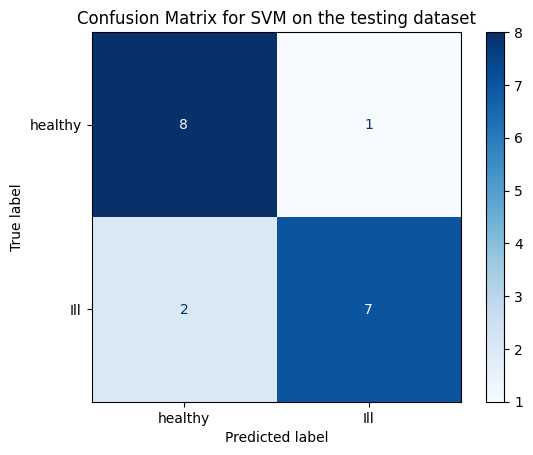

In [6]:
# Predict on the testing dataset using the best SVM classifier with PCA features
best_svm_classifier = grid_search.best_estimator_
y_test_pred = best_svm_classifier.predict(X_test_pca)

# Generate classification report for the testing dataset
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for SVM on the testing dataset:\n", test_report)

# Calculate the confusion matrix for the testing dataset
test_cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "Ill"])
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the testing dataset")
plt.show()

Classification Report for SVM on the training dataset:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93        97
           1       0.90      0.87      0.89        63

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160



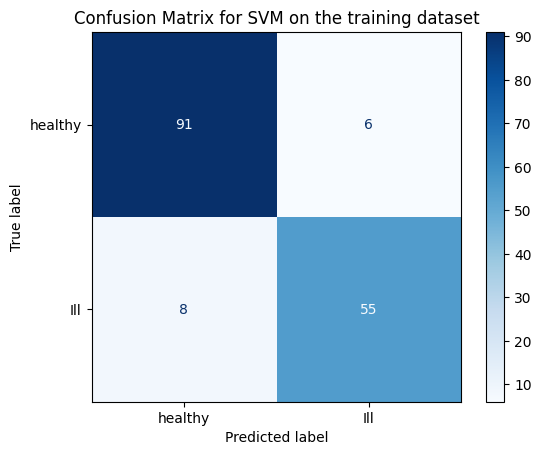

In [7]:
# Predict on the training dataset using the best SVM classifier with PCA features
y_train_pred = best_svm_classifier.predict(X_train_pca)

# Generate classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for SVM on the training dataset:\n", train_report)

# Calculate the confusion matrix for the training dataset
train_cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "Ill"])
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the training dataset")
plt.show()

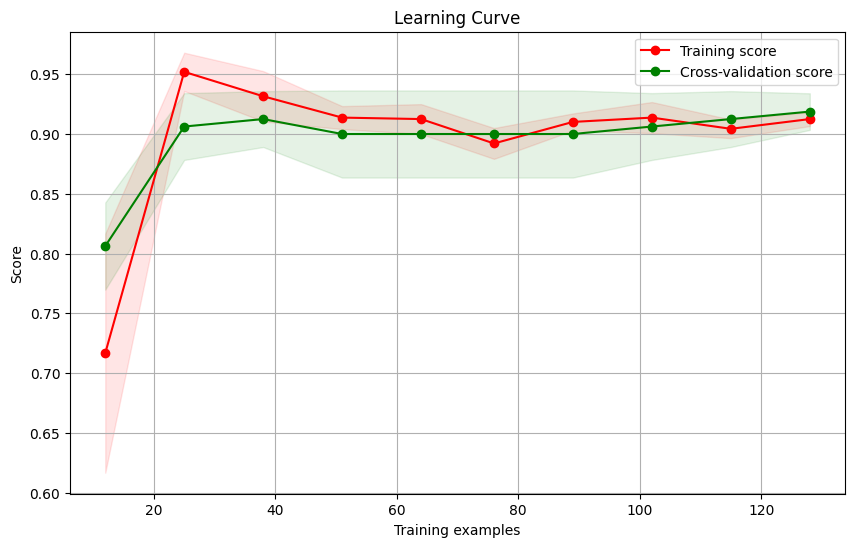

In [9]:
from sklearn.model_selection import learning_curve
# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_svm_classifier, X_train_pca, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()